# Retraining ResNet50

This notebook will guide you through the process of retraining ResNet50 using the skin cancer dataset.

In [55]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.resnet import ResNet50, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.regularizers import l2,l1_l2,l1
import tensorflow as tf
from sklearn.utils import class_weight

%matplotlib inline
import matplotlib.pyplot as plt

## Load in the Dataset

In [56]:
X_train = np.load("224_224_train.npy")

In [57]:
y_train = np.load("train_labels_224.npy")

In [58]:
X_val = np.load("224_224_val.npy")

In [59]:
y_val = np.load("val_labels_224.npy")

In [60]:
X_train.shape, X_val.shape

((37989, 224, 224, 3), (902, 224, 224, 3))

In [61]:
y_train.shape, y_val.shape

((37989,), (902,))

In [62]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [63]:
y_train.shape, y_val.shape

((37989,7), (902,7))

## Load in Pretrained Inception Model

In [64]:
pre_trained_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [65]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = True
    
print(len(pre_trained_model.layers))

input_3
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [66]:
last_layer = pre_trained_model.get_layer('conv5_block3_out')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 2048)


## Define the Model

In [67]:
# Flattening the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Adding a fully connected layer with 512 hidden units and ReLU activation
# x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.7)(x)  # Increased dropout
# Adding a final softmax layer for classification
x = layers.Dense(7, activation='softmax', kernel_regularizer=l1_l2(l1=0.01, l2=0.001))(x)

# Configuring and compiling the model
model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

c:\Users\chara_eoccfea\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [68]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Training

Here we retrain using the whole model instead of performing transfer learning. The reason for this is the issue with batch-normalization layer In this process, we opt to retrain the entire model rather than engaging in transfer learning. This decision is driven by an issue with the batch-normalization layer in Keras. During training, the network consistently utilizes mini-batch statistics, regardless of whether the BN layer is frozen or not. Additionally, during inference, it relies on the previously learned statistics of the frozen BN layers. Consequently, fine-tuning the top layers could lead to their weights being adjusted to the mean/variance of the new dataset. However, during inference, they would receive data scaled differently, as the mean/variance of the original dataset would be applied.

To address this issue, refer to: Keras Pull Request #9965 and Keras Issue #9214. For now, the approach is to retrain the entire model with a very small learning_rate (0.0001) and a large momentum, accompanied by a learning_rate_reduction function. This function halves the learning rate whenever the validation accuracy remains unchanged for three consecutive epochs. The training is limited to 20 epochs to ensure that the weights of the original pretrained model do not undergo significant changes and avoid overfitting the training data.

### Feature Extraction

Prior to initiating the retraining process, it is advisable to freeze all the layers in ResNet50. This involves training only the top fully-connected and classification layers so that their weights are not initialized randomly. The rationale behind this approach is to prevent excessive changes to the pretrained weights, as the absence of feature extraction would lead to large gradients.

In [69]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [70]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001)

In [71]:
def custom_normalization(x):
    return (x/255.0 - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_normalization,
    rotation_range=180, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator(preprocessing_function=custom_normalization)
val_datagen.fit(X_val)

In [73]:
batch_size = 64
epochs = 3
early_stopping = EarlyStopping(patience=5)
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=val_datagen.flow(X_val, y_val),
    verbose=1,
    steps_per_epoch=X_train.shape[0] // batch_size,
    validation_steps=X_val.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/3
1057/1057 [==============================] - 223s 235ms/step - loss: 1.5004 - accuracy: 0.5377 - val_loss: 0.9733 - val_accuracy: 0.7279
Epoch 2/3
1057/1057 [==============================] - 245s 234ms/step - loss: 0.8179 - accuracy: 0.7158 - val_loss: 0.8515 - val_accuracy: 0.8245
Epoch 3/3
1057/1057 [==============================] - 241s 234ms/step - loss: 0.5236 - accuracy: 0.8385 - val_loss: 0.7903 - val_accuracy: 0.8321


### Retraining

Currently, we are retraining the entire model with the objective of fine-tuning the weights slightly for our dataset while minimizing significant alterations to the pretrained weights.

In [74]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [75]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [76]:
batch_size = 64
epochs = 25

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs, validation_data=val_datagen.flow(X_val, y_val),
    verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
    validation_steps=X_val.shape[0] // batch_size,
    )


Epoch 1/25
1057/1057 [==============================] - 248s 235ms/step - loss: 1.7004 - accuracy: 0.6377 - val_loss: 0.9433 - val_accuracy: 0.7479
Epoch 2/25
1057/1057 [==============================] - 247s 234ms/step - loss: 0.9179 - accuracy: 0.8158 - val_loss: 0.7515 - val_accuracy: 0.8558
Epoch 3/25
1057/1057 [==============================] - 247s 234ms/step - loss: 0.7236 - accuracy: 0.8785 - val_loss: 0.7903 - val_accuracy: 0.8814
Epoch 4/25
1057/1057 [==============================] - 247s 234ms/step - loss: 0.6052 - accuracy: 0.9162 - val_loss: 0.5245 - val_accuracy: 0.9059
Epoch 5/25
1057/1057 [==============================] - 247s 234ms/step - loss: 0.5404 - accuracy: 0.9348 - val_loss: 0.3900 - val_accuracy: 0.9307
Epoch 6/25
1057/1057 [==============================] - 247s 234ms/step - loss: 0.4819 - accuracy: 0.9492 - val_loss: 0.4624 - val_accuracy: 0.9102
Epoch 7/25
1057/1057 [==============================] - 247s 234ms/step - loss: 0.4278 - accuracy: 0.9616 - val_

In [81]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 2s 77ms/step - loss: 0.2946 - acc: 0.9752
Validation: accuracy = 0.975188  ;  loss_v = 0.294638


Despite the observed overfitting to the training data, notable enhancements in validation accuracy are evident. The final validation accuracy reaches 86.9%, reflecting an approximate 10% improvement compared to the baseline model. This improvement justifies allocating additional time for training. Additionally, it is worth noting that this model is highly "sensitive," with even a slight adjustment in the learning rate causing substantial changes. Future efforts should focus on refining the selection of the learning rate and closely monitoring its behavior for further enhancements.

## Testing

Let's load in the intact test set and test our model

In [78]:
X_test = np.load("224_224_test.npy")

In [79]:
y_test = np.load("test_labels_224.npy")
y_test = to_categorical(y_test)

In [80]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 2s 67ms/step - loss: 0.2756 - acc: 0.9692
Test: accuracy = 0.96842  ;  loss = 0.275541


Attaining a test accuracy of 86.8% following 20 training epochs is a commendable outcome! This experiment substantiates that the architecture and weights of Inception, pretrained on ImageNet, facilitate learning for a wholly distinct domain dataset.

In [ ]:
model.save("ResNet50.h5")

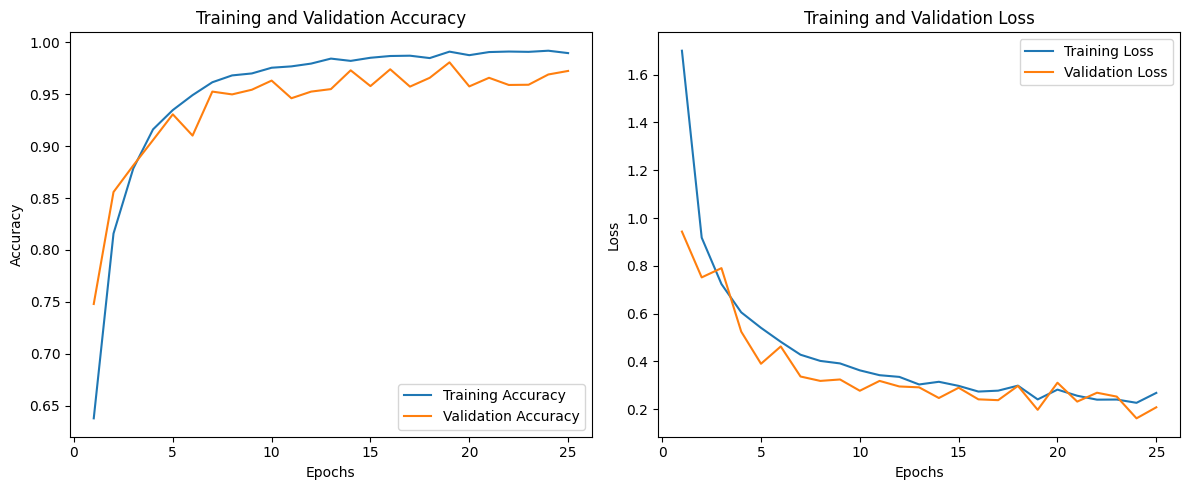

In [1]:
# Retrieving a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieving a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Getting number of epochs
epochs = range(len(acc))

# Plotting training and validation accuracy per epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()